In [ ]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git;

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-m56h1q1s
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-m56h1q1s
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp36-none-any.whl size=4308 sha256=92ba0d28f56cdf8c8e5c76839dbd54be70679388d833368ade716a18eb7f0827
  Stored in directory: /tmp/pip-ephem-wheel-cache-yyoxm4t4/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin;

created output directory at /content/src
Out bin /content/result.out


In [ ]:
%%cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#define u(n, k) u[n*Nx + k]

typedef struct {
    double a;
    double b;
} tuple;

__host__ static double* range(double start, double stop, double step) {
    int size = (stop - start)/step + 1;
    double* x; // Allocate Device Memory
    cudaMallocManaged(&x, sizeof(double) * size);
    if (x) { // Allocation Check
        for (int i = 0; i < size; i++)
            x[i] = start + i*step;
    } return x;
}

__device__ static double f(double x) {
    double x0 = 25; // Gaussian Pulse Center
    return exp(-0.1*(x - x0)*(x - x0));
}

__device__ static double g(double x) {
    return 0; // split with half amplitude

    // double x0 = 25; // Gaussian Pulse Center
    // return  0.2*(x - x0)*f(x); // propogate right
    // return -0.2*(x - x0)*f(x); // propogate left
}

__global__ // CUDA Kernel Function
static void solvepde(double u[], double x[]) {
    tuple tspan, xspan;
    tspan.a = 0, tspan.b = 50;
    xspan.a = 0, xspan.b = 100;
    double ht = 0.2, hx = 0.2;

    int Nt = (tspan.b - tspan.a)/ht + 1;
    int Nx = (xspan.b - xspan.a)/hx + 1;
    double c = ht/hx;

    for (int k = 0; k < Nx; k++)
        u(0, k) = f(x[k]);
    u(0, 0) = u(0, Nx - 1) = 0;
    u(1, 0) = u(1, Nx - 1) = 0;
    for (int k = 1; k < (Nx - 1); k++)
        u(1, k) = 0.5*(c*c)*f(x[k + 1]) + (1 - c*c)*f(x[k]) + 0.5*(c*c)*f(x[k - 1]) + ht*g(x[k]);

    for (int n = 2; n < Nt; n++) {
        for (int k = 1; k < (Nx - 1); k++) {
            u(2, k) = (c*c)*u(1, k + 1) + 2*(1 - c*c)*u(1, k) + (c*c)*u(1, k - 1) - u(0, k);
        }
        u(2, 0) = u(2, Nx - 1) = 0;
        for (int k = 0; k < Nx; k++)
            u(0, k) = u(1, k), u(1, k) = u(2, k), u(2, k) = 0;
    }
}

int main() {
    double* x = range(0, 100, 0.2);
    int Nx = (100)/0.2 + 1;

    double* u; // Allocate Unified Memory
    cudaMallocManaged(&u, sizeof(double) * 3*Nx);

    solvepde<<<1, 1>>>(u, x);

    cudaDeviceSynchronize();

    FILE *file = fopen("wavefunc_CUDA.txt", "wb");
    for (int k = 0; k < Nx; k++)
        fprintf(file, "%lf %0.15f\n", x[k], u(1, k));
    fclose(file);

    cudaFree(u); cudaFree(x);

    printf("Finished!");

    return 0;
}


Finished!


In [ ]:
%%cu 

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#define u(n, k) u[n*Nx + k]

typedef struct {
    double a;
    double b;
} tuple;

__host__ static double* range(double start, double stop, double step) {
    int size = (stop - start)/step + 1;
    double* x; // Allocate Device Memory
    cudaMallocManaged(&x, sizeof(double) * size);
    if (x) { // Allocation Check
        for (int i = 0; i < size; i++)
            x[i] = start + i*step;
    } return x;
}

__device__ static double f(double x) {
    double x0 = 25; // Gaussian Pulse Center
    return exp(-0.1*(x - x0)*(x - x0));
}

__device__ static double g(double x) {
    return 0; // split with half amplitude

    // double x0 = 25; // Gaussian Pulse Center
    // return  0.2*(x - x0)*f(x); // propogate right
    // return -0.2*(x - x0)*f(x); // propogate left
}

__global__ // CUDA Kernel Function
static void solvepde(double u[], double x[]) {
    tuple tspan, xspan;
    tspan.a = 0, tspan.b = 50;
    xspan.a = 0, xspan.b = 100;
    double ht = 0.2, hx = 0.2;

    int Nt = (tspan.b - tspan.a)/ht + 1;
    int Nx = (xspan.b - xspan.a)/hx + 1;
    double c = ht/hx;

    int index = threadIdx.x;
    int stride = blockDim.x;

    for (int k = 0; k < Nx; k++)
        u(0, k) = f(x[k]);
    u(0, 0) = u(0, Nx - 1) = 0;
    u(1, 0) = u(1, Nx - 1) = 0;
    for (int k = 1; k < (Nx - 1); k++)
        u(1, k) = 0.5*(c*c)*f(x[k + 1]) + (1 - c*c)*f(x[k]) + 0.5*(c*c)*f(x[k - 1]) + ht*g(x[k]);

    for (int n = 2; n < Nt; n++) {
        for (int k = index; k < (Nx - 1); k += stride) {
            u(2, k) = (c*c)*u(1, k + 1) + 2*(1 - c*c)*u(1, k) + (c*c)*u(1, k - 1) - u(0, k);
        }
        u(2, 0) = u(2, Nx - 1) = 0;
        for (int k = 0; k < Nx; k++)
            u(0, k) = u(1, k), u(1, k) = u(2, k), u(2, k) = 0;
    }
}

int main() {
    double* x = range(0, 100, 0.2);
    int Nx = (100)/0.2 + 1;

    double* u; // Allocate Unified Memory
    cudaMallocManaged(&u, sizeof(double) * 3*Nx);

    solvepde<<<1, 64>>>(u, x);

    cudaDeviceSynchronize();

    FILE *file = fopen("wavefunc_CUDA.txt", "wb");
    for (int k = 0; k < Nx; k++)
        fprintf(file, "%lf %0.15f\n", x[k], u(1, k));
    fclose(file);

    cudaFree(u); cudaFree(x);

    printf("Finished!");

    return 0;
}


Finished!


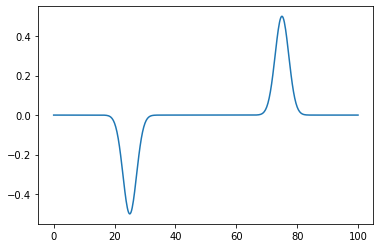

In [ ]:
from matplotlib import pyplot as plt
from numpy import loadtxt
import sys

data = loadtxt('wavefunc_CUDA.txt')
name = sys.argv[1].split('.')[0]
x, y = data[:, 0], data[:, 1]
plt.plot(x, y);

In [ ]:
# !cat /proc/cpuinfo
!lspci

/bin/bash: lspci: command not found
